# Load previously selected subdivision samples and feature

The file being imported below was constructed in the last exploratory notebooks (2.2-rp-hcad-eda-appraised-value-perc-diff-subdiv-comps-hypothesis-test). These data have been cleaned, merged, and selected so we can start preparing it for modeling.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path
import pickle

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from src.definitions import ROOT_DIR
from src.data.utils import save_pickle

In [3]:
plt.style.use('seaborn-poster')

In [4]:
subdiv_fn = ROOT_DIR / 'data/interim/2016/subdiv.pickle'
assert subdiv_fn.exists()

In [5]:
subdiv = pd.read_pickle(subdiv_fn)

In [6]:
subdiv.sample(10)

,date_erected,im_sq_ft,act_ar,heat_ar,gross_ar,eff_ar,perimeter,fireplace_metal_prefab,fixtures_addl,fixtures_total,...,new_own_dt,lgl_1,base_area_pri,base_area_upr,mas_brk_garage_pri,open_frame_porch_pri,open_mas_porch_pri,exterior_wall,yy_pct_change,kmeans_label
acct,,,,,,,,,,,,,,,,,,,,,
1347180030033,2014,1924.0,2518,1924.0,2518,2140.0,222.0,0.0,2.0,10.0,...,2015-03-06,LT 33 BLK 3,1924.0,0.0,399.0,171.0,24.0,Stone,0.299534,0
1347180010033,2014,2244.0,2868,2244.0,2868,2469.0,230.0,1.0,3.0,11.0,...,2015-01-29,LT 33 BLK 1,2244.0,0.0,380.0,196.0,48.0,Brick / Veneer,-0.028585,0
1347180020029,2014,1844.0,2418,1844.0,2418,2055.0,218.0,0.0,2.0,10.0,...,2015-06-25,LT 29 BLK 2,1844.0,0.0,420.0,112.0,42.0,Stone,1.322580,0
1347180010031,2014,1986.0,2572,1986.0,2572,2198.0,222.0,1.0,2.0,10.0,...,2014-12-18,LT 31 BLK 1,1986.0,0.0,380.0,171.0,35.0,Frame / Concrete Blk,0.068341,0
1347180010019,2014,1844.0,2406,1844.0,2406,2051.0,218.0,0.0,2.0,10.0,...,2015-03-06,LT 19 BLK 1,1844.0,0.0,420.0,112.0,30.0,Frame / Concrete Blk,0.299849,0
1347180010020,2014,2942.0,3672,2942.0,3672,3077.0,376.0,1.0,2.0,15.0,...,2015-05-27,LT 20 BLK 1,1776.0,1166.0,399.0,220.0,57.0,Stone,1.033745,2
1347180030001,2014,2346.0,2992,2346.0,2992,2484.0,376.0,1.0,2.0,12.0,...,2015-06-23,LT 1 BLK 3,1356.0,990.0,474.0,88.0,84.0,Frame / Concrete Blk,1.206337,2
1347180030028,2014,1876.0,2542,1876.0,2542,2116.0,222.0,1.0,2.0,10.0,...,2014-08-29,LT 28 BLK 3,1876.0,0.0,400.0,120.0,146.0,Frame / Concrete Blk,0.020907,1
1347180010026,2014,1840.0,2424,1840.0,2424,2054.0,218.0,0.0,2.0,10.0,...,2016-05-24,LT 26 BLK 1,1840.0,0.0,420.0,122.0,42.0,Frame / Concrete Blk,1.082838,0


# Drop previous year related features
Since some of the houses weren't finished by January of the prior year (2015), features that use the prior year value will be bias towards lower values. Let's drop these features.

In [7]:
subdiv.shape

(110, 33)

In [8]:
subdiv.info()

<class 'pandas.core.frame.DataFrame'>
UInt64Index: 110 entries, 1347180010011 to 1347180030030
Data columns (total 33 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   date_erected            110 non-null    uint16        
 1   im_sq_ft                110 non-null    float64       
 2   act_ar                  110 non-null    uint16        
 3   heat_ar                 110 non-null    float64       
 4   gross_ar                110 non-null    uint16        
 5   eff_ar                  110 non-null    float64       
 6   perimeter               110 non-null    float64       
 7   fireplace_metal_prefab  110 non-null    float32       
 8   fixtures_addl           110 non-null    float32       
 9   fixtures_total          110 non-null    float32       
 10  room_bedroom            110 non-null    float32       
 11  room_full_bath          110 non-null    float32       
 12  room_half_bath          110

In [9]:
drop = [
    'yy_pct_change', # Some of the houses weren't finished in 2015
    'prior_land_val', # Some of the houses weren't finished in 2015
    'prior_tot_appr_val', # Some of the houses weren't finished in 2015
    'new_own_dt', # Latest purchase date
    'lgl_1', # House lot
]

In [10]:
subdiv.drop(drop, axis=1, inplace=True)

In [11]:
subdiv.info()

<class 'pandas.core.frame.DataFrame'>
UInt64Index: 110 entries, 1347180010011 to 1347180030030
Data columns (total 28 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   date_erected            110 non-null    uint16  
 1   im_sq_ft                110 non-null    float64 
 2   act_ar                  110 non-null    uint16  
 3   heat_ar                 110 non-null    float64 
 4   gross_ar                110 non-null    uint16  
 5   eff_ar                  110 non-null    float64 
 6   perimeter               110 non-null    float64 
 7   fireplace_metal_prefab  110 non-null    float32 
 8   fixtures_addl           110 non-null    float32 
 9   fixtures_total          110 non-null    float32 
 10  room_bedroom            110 non-null    float32 
 11  room_full_bath          110 non-null    float32 
 12  room_half_bath          110 non-null    float32 
 13  room_rec                110 non-null    float32 
 14  roo

# Create dummy features for categorical variables
Since the `exterior_wall` category was created using all the houses in HCAD, there are seven categories that are not present in this subdivision. Let's remove them from the possible categories list so the `pd.get_dummy` method doesn't get confused.

In [12]:
subdiv['exterior_wall'].value_counts()

Brick / Veneer          43
Frame / Concrete Blk    36
Stone                   31
Stucco                   0
Shake Shingle            0
Metal, Light             0
Frame / Res Stucco       0
Brick / Masonry          0
Asbestos                 0
Aluminum / Vinyl         0
Name: exterior_wall, dtype: int64

In [13]:
subdiv['exterior_wall'] = subdiv['exterior_wall'].cat.remove_unused_categories()

In [14]:
subdiv['exterior_wall'].value_counts()

Brick / Veneer          43
Frame / Concrete Blk    36
Stone                   31
Name: exterior_wall, dtype: int64

In [15]:
from sklearn.preprocessing import OneHotEncoder

In [16]:
cat_cols = ['exterior_wall', 'kmeans_label']

In [17]:
subdiv_cat_cols = subdiv.loc[:, cat_cols]

In [18]:
subdiv_cat_cols

,exterior_wall,kmeans_label
acct,,
1347180010011,Frame / Concrete Blk,2
1347180010013,Stone,0
1347180010021,Brick / Veneer,2
1347180010023,Frame / Concrete Blk,0
1347180010035,Stone,0
...,...,...
1347180030016,Frame / Concrete Blk,2
1347180030018,Brick / Veneer,0
1347180030022,Brick / Veneer,2


In [19]:
enc = OneHotEncoder()
enc.fit(subdiv_cat_cols)

OneHotEncoder()

In [20]:
encoded = enc.transform(subdiv_cat_cols).toarray()

In [21]:
encoded_col_names = enc.get_feature_names(cat_cols)

In [22]:
df_encoded = pd.DataFrame(encoded, columns=encoded_col_names, index=subdiv_cat_cols.index)

In [23]:
subdiv_dummy = pd.concat([subdiv.drop(labels=cat_cols, axis=1), df_encoded], axis=1)

In [24]:
subdiv_dummy.head()

,date_erected,im_sq_ft,act_ar,heat_ar,gross_ar,eff_ar,perimeter,fireplace_metal_prefab,fixtures_addl,fixtures_total,...,base_area_upr,mas_brk_garage_pri,open_frame_porch_pri,open_mas_porch_pri,exterior_wall_Brick / Veneer,exterior_wall_Frame / Concrete Blk,exterior_wall_Stone,kmeans_label_0,kmeans_label_1,kmeans_label_2
acct,,,,,,,,,,,,,,,,,,,,,
1347180010011,2014,2869.0,3545,2869.0,3545,3003.0,374.0,1.0,2.0,15.0,...,1105.0,399.0,220.0,57.0,0.0,1.0,0.0,0.0,0.0,1.0
1347180010013,2014,1858.0,2524,1858.0,2524,2098.0,218.0,0.0,2.0,10.0,...,0.0,399.0,112.0,155.0,0.0,0.0,1.0,1.0,0.0,0.0
1347180010021,2014,2579.0,3214,2579.0,3214,2683.0,230.0,1.0,2.0,15.0,...,0.0,399.0,136.0,100.0,1.0,0.0,0.0,0.0,0.0,1.0
1347180010023,2014,2031.0,2626,2031.0,2626,2246.0,234.0,1.0,2.0,10.0,...,0.0,396.0,119.0,80.0,0.0,1.0,0.0,1.0,0.0,0.0
1347180010035,2014,2371.0,3133,2371.0,3133,2458.0,216.0,0.0,2.0,12.0,...,0.0,566.0,100.0,96.0,0.0,0.0,1.0,1.0,0.0,0.0


## Save modeling data

In [25]:
save_fn = ROOT_DIR / 'data/processed/subdiv_dummy.pickle'
save_pickle(subdiv_dummy, save_fn)

save_fn = ROOT_DIR / 'models/enc.pickle'
save_pickle(enc, save_fn)

# Split data

In [26]:
from sklearn.model_selection import train_test_split

In [27]:
X = subdiv_dummy.drop(['tot_appr_val'], axis=1)
y = subdiv_dummy['tot_appr_val']

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# 5-fold cross-validation, feature selection and modeling

I'll follow a variant of the steps on page [245 of Hastie, Tibshirani, and Friedman (2009)](https://web.stanford.edu/~hastie/ElemStatLearn/). The idea is to perform all data processing steps that depend on all the samples within each fold in the cross-validation. This way, we minimize the possibility of information leaking into the training set, which could cause artificially low test errors. A great explanation of the step-by-step procedure is presented in [Raschka 2016 blog post](https://sebastianraschka.com/blog/2016/model-evaluation-selection-part3.html).

In this case, I first split the data (previous step) and use the training data in cross-validation to:
1. Fit a random forest estimator
2. Standardize the variables
3. Fit an ElasticNet estimator
4. Fit a ridge regression estimator
5. Fit a LASSO estimator for feature elimination
6. Fit a ridge regression estimator with features passed by LASSO

By summarizing the model scores across fold (cross-validation error) we can form an idea of the prediction error on unseen data, and the stability of the hyperparameters

In [29]:
from collections import defaultdict

In [30]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import ElasticNetCV, RidgeCV, LassoCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, median_absolute_error

In [31]:
def model_scores(model, X_train, y_train, X_test, y_test, sc_y=None):
    '''Evaluate model using test data'''
    
    data_split = {'train': (X_train, y_train),
                  'test': (X_test, y_test)}

    results = {}
    for split_type, data in data_split.items():
        X, y_true = data
        
        y_pred = model.predict(X)
         
        if sc_y:
            y_pred = sc_y.inverse_transform(y_pred)
            y_true = sc_y.inverse_transform(y_true)
        
        mae = mean_absolute_error(y_true, y_pred)
        mse = mean_squared_error(y_true, y_pred)
        medae = median_absolute_error(y_true, y_pred)
        
        results[split_type+'_scores'] = {'mae': mae,
                                         'mse': mse,
                                         'medae': medae}
    
    return results

In [32]:
kf = KFold(n_splits=5)

In [33]:
cv_results_fn = ROOT_DIR / 'models/cv_results.pickle'

In [34]:
if cv_results_fn.is_file():
    with open(cv_results_fn, 'rb') as f:
        cv_results = pickle.load(f)
else:
    cv_results = defaultdict(dict)
    for fold, indexes in enumerate(kf.split(X_train)):

        train_index, test_index = indexes

        X_fold_train, X_fold_test = X_train.iloc[train_index, :], X_train.iloc[test_index, :]
        y_fold_train, y_fold_test = y_train.iloc[train_index], y_train.iloc[test_index]

        # CV random forest
        print(f'Start RF, fold {fold}')
        rf = RandomForestRegressor()
        rf_params = {'n_estimators': np.arange(100, 1500, 100)}
        rf_cv = GridSearchCV(rf, rf_params, cv=5)
        rf_cv.fit(X_fold_train, y_fold_train)

        scores = model_scores(rf_cv, X_fold_train, y_fold_train, X_fold_test, y_fold_test)

        rf_feature_importances = rf_cv.best_estimator_.feature_importances_

        scores.update({'features': rf_feature_importances,
                       'model': rf_cv,
                       'n_estimators': rf_cv.best_params_['n_estimators']})

        cv_results[fold].update({'rf': scores})

        # Standardize variables
        print(f'Start Standarize variables, fold {fold}')
        sc_x = StandardScaler()
        sc_y = StandardScaler()
        sc_x.fit(X_fold_train)
        sc_y.fit(y_fold_train.to_numpy().reshape(-1, 1))

        X_fold_train_std = sc_x.transform(X_fold_train)
        X_fold_test_std = sc_x.transform(X_fold_test)

        y_fold_train_std = sc_y.transform(y_fold_train.to_numpy().reshape(-1, 1)).ravel()
        y_fold_test_std = sc_y.transform(y_fold_test.to_numpy().reshape(-1, 1)).ravel()

        # ElasticNet
        print(f'Start ElasticNet, fold {fold}')
        l1_ratios = [.1, .5, .7, .9, .95, .99, 1]
        en_cv = ElasticNetCV(l1_ratio=l1_ratios, cv=5, n_jobs=-1, max_iter=15000)
        en_cv.fit(X_fold_train_std, y_fold_train_std)

        scores = model_scores(en_cv,
                              X_fold_train_std,
                              y_fold_train_std,
                              X_fold_test_std,
                              y_fold_test_std,
                              sc_y)
        scores.update({'model': en_cv,
                       'alpha': en_cv.alpha_,
                       'l1_ratio': en_cv.l1_ratio_,
                       'coeff': en_cv.coef_})

        cv_results[fold].update({'en': scores})

        # Ridge regression
        print(f'Start Ridge regression, fold {fold}')
        alphas=np.logspace(-10, 10, 21)
        rr_cv = RidgeCV(alphas=alphas, cv=5)
        rr_cv.fit(X_fold_train_std, y_fold_train_std)

        scores = model_scores(rr_cv,
                              X_fold_train_std,
                              y_fold_train_std,
                              X_fold_test_std,
                              y_fold_test_std,
                              sc_y)

        scores.update({'model': rr_cv,
                       'alpha': rr_cv.alpha_,
                       'coeff': rr_cv.coef_})

        cv_results[fold].update({'rr': scores})

        # LASSO for feature selection
        print(f'Start LASSO, fold {fold}')
        lasso_cv = LassoCV(cv=5, max_iter=10000, n_jobs=-1)
        lasso_cv.fit(X_fold_train_std, y_fold_train_std)

        scores = model_scores(lasso_cv,
                              X_fold_train_std,
                              y_fold_train_std,
                              X_fold_test_std,
                              y_fold_test_std,
                              sc_y)

        selected_features_idx = [col_indx
                                 for col_indx, coef in enumerate(lasso_cv.coef_)
                                 if not np.isclose(coef, 0)]

        X_fold_train_std_fe = X_fold_train_std[:, selected_features_idx]
        X_fold_test_std_fe = X_fold_test_std[:, selected_features_idx]

        scores.update({'model': lasso_cv,
                       'alpha': lasso_cv.alpha_,
                       'coeff': lasso_cv.coef_,
                       'features': X_fold_train.columns[(selected_features_idx)]})

        cv_results[fold].update({'lasso': scores})

        # Ridge regression with selected features
        print(f'Start Ridge regression with fe, fold {fold}')

        # Must rebuild X standard scaler to account for dropped features
        X_fold_train_fe = X_fold_train.iloc[:, selected_features_idx]
        X_fold_test_fe = X_fold_test.iloc[:, selected_features_idx]

        sc_x_fe = StandardScaler()
        sc_x_fe.fit(X_fold_train_fe)

        X_fold_train_fe_std = sc_x_fe.transform(X_fold_train_fe)
        X_fold_test_fe_std = sc_x_fe.transform(X_fold_test_fe)


        rr_fe_cv = RidgeCV(alphas=alphas, cv=5)
        rr_fe_cv.fit(X_fold_train_fe_std, y_fold_train_std)

        scores = model_scores(rr_fe_cv,
                              X_fold_train_fe_std,
                              y_fold_train_std,
                              X_fold_test_fe_std,
                              y_fold_test_std,
                              sc_y)
        scores.update({'model': rr_fe_cv,
                       'alpha': rr_fe_cv.alpha_,
                       'coeff': rr_fe_cv.coef_})

        cv_results[fold].update({'rr_fe': scores})
        
    # Save results
    save_pickle(cv_results, cv_results_fn)

In [35]:
cv_results

defaultdict(dict,
            {0: {'rf': {'train_scores': {'mae': 3780.9918032786886,
                'mse': 51902047.255977035,
                'medae': 2306.890000000014},
               'test_scores': {'mae': 10558.680000000002,
                'mse': 211331473.8140875,
                'medae': 7090.9800000000105},
               'features': array([3.11388474e-04, 4.50829962e-02, 7.23372657e-02, 4.39200642e-02,
                      5.42263693e-02, 5.32367765e-01, 4.77259895e-02, 3.87786497e-03,
                      3.98224735e-04, 8.98633137e-04, 7.03793217e-04, 3.87600289e-04,
                      3.03604420e-04, 8.69948258e-04, 2.84634918e-03, 4.26467238e-03,
                      4.91505797e-02, 5.53610456e-03, 3.87475361e-03, 3.09066312e-03,
                      3.35216065e-02, 1.01946217e-02, 8.98648147e-03, 3.48535144e-03,
                      4.57530421e-02, 1.57944418e-03, 2.19636193e-03, 2.27287336e-03,
                      1.91553168e-03, 1.87344932e-03, 1.60466063e-

## Explore train and test errors
Let's look at the prediction errors defined by the median absolute error (medae).

In [36]:
eval_score = 'medae'

In [37]:
model_params = [('rf', 'n_estimators', np.nan),
                ('en', 'alpha', 'l1_ratio'),
                ('rr', 'alpha', np.nan),
                ('lasso', 'alpha', np.nan),
                ('rr_fe', 'alpha', np.nan)]

In [38]:
score_cols = defaultdict(list)

In [39]:
for fold, values in cv_results.items():
    for model, param_1, param_2 in model_params:
        score_cols['fold'].append(fold)
        score_cols['model'].append(model)
        score_cols['train_score'].append(values[model]['train_scores'][eval_score])
        score_cols['test_score'].append(values[model]['test_scores'][eval_score])
        score_cols['param_1'].append(values[model][param_1])
        
        # Check if it is np.nan
        if isinstance(param_2, float):
            score_cols['param_2'].append(param_2)
        else:
            score_cols['param_2'].append(values[model][param_2])

In [40]:
scores = pd.DataFrame.from_dict(score_cols)

In [41]:
scores

,fold,model,train_score,test_score,param_1,param_2
0,0,rf,2306.890000,7090.980000,1.000000e+02,NaN
1,0,en,5513.312320,2533.395164,1.398627e-01,1.0
2,0,rr,4634.509785,5621.743675,1.000000e+02,NaN
3,0,lasso,5513.312320,2533.395164,1.398627e-01,NaN
4,0,rr_fe,5296.525021,5698.130294,1.000000e-10,NaN
5,1,rf,1691.345000,5191.091250,4.000000e+02,NaN
6,1,en,4510.268720,5964.556213,1.668440e-01,1.0
7,1,rr,4203.469390,4135.652149,1.000000e+02,NaN
8,1,lasso,4510.268720,5964.556213,1.668440e-01,NaN
9,1,rr_fe,4037.830887,7847.662412,1.000000e+00,NaN


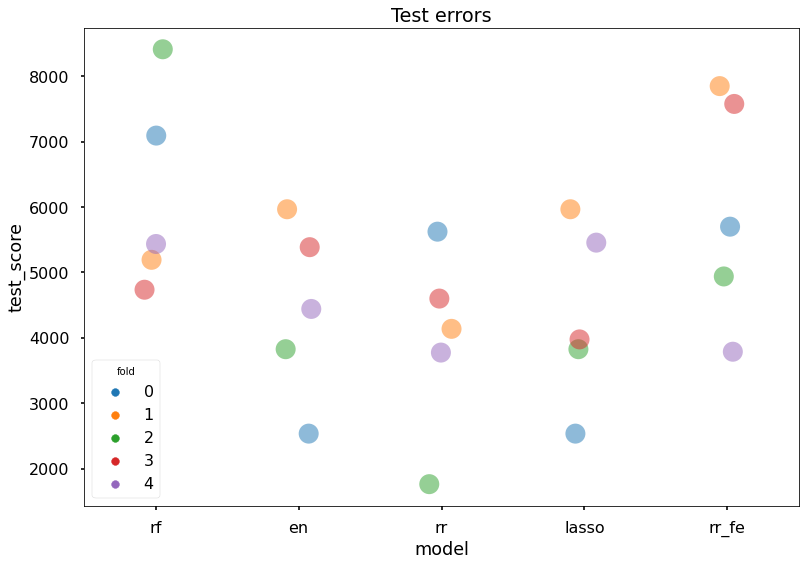

In [42]:
ax = sns.stripplot(x='model', y='test_score', hue='fold', data=scores, alpha=0.5, size=20)
_ = ax.set_title('Test errors')

Text(0.5, 1.0, 'Train errors')

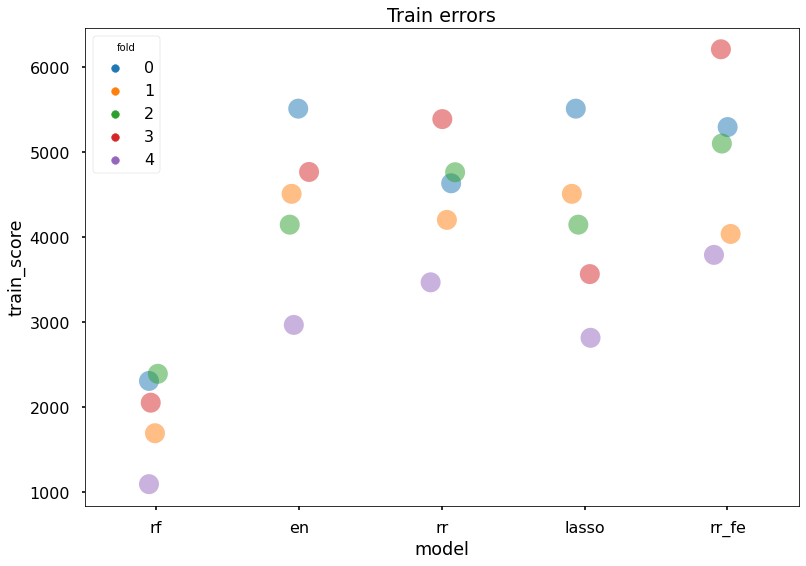

In [43]:
ax = sns.stripplot(x='model', y='train_score', hue='fold', data=scores, alpha=0.5, size=20)
ax.set_title('Train errors')

Ridge regression produces the lowest test errors. Overall, LASSO, ElasticNet, and ridge regression have a similar cross-validation test errors, while random forest and ridge regression with feature elimination are the worst performers. Base on this plot I'd select the ridge regression estimator, as it produces the smallest maximum and the smallest minimum cross-validation error.

Now let's look at the stability of the ridge regression parameter alpha.

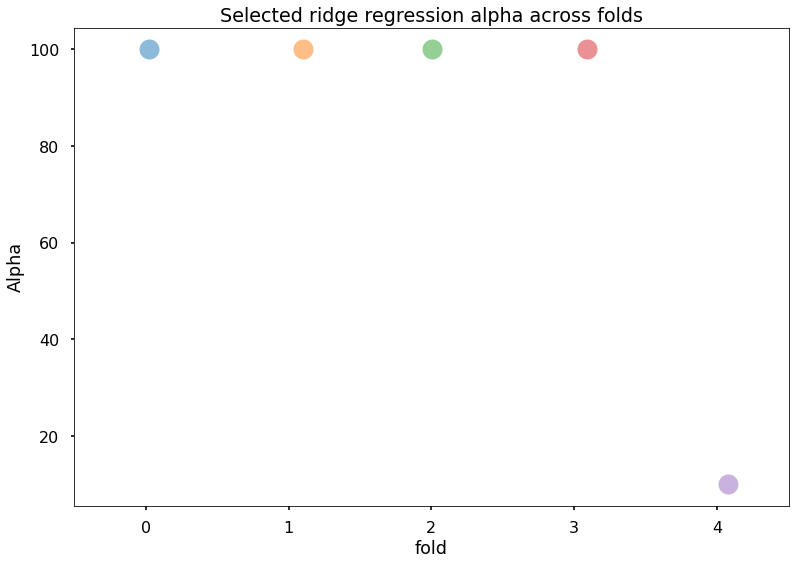

In [44]:
data = scores.loc[scores['model'] == 'rr', :]
ax = sns.stripplot(x='fold', y='param_1', data=data, alpha=0.5, size=20)
_ = plt.ylabel('Alpha')
_ = ax.set_title('Selected ridge regression alpha across folds')

The ridge regression penalty term alpha takes values of 10 or 100, the latter being favored by four out of the 5 folds in the cross-validation. For this reason, I'll run the final fit using alpha equal to 100.

## Feature elimination results
Let's look at the feature importance returned by the random forest estimator and compare them to the LASSO features coefficients.

In [45]:
X_train.columns

Index(['date_erected', 'im_sq_ft', 'act_ar', 'heat_ar', 'gross_ar', 'eff_ar',
       'perimeter', 'fireplace_metal_prefab', 'fixtures_addl',
       'fixtures_total', 'room_bedroom', 'room_full_bath', 'room_half_bath',
       'room_rec', 'room_total', 'story_height_index', 'bld_ar', 'land_ar',
       'acreage', 'land_val', 'base_area_pri', 'base_area_upr',
       'mas_brk_garage_pri', 'open_frame_porch_pri', 'open_mas_porch_pri',
       'exterior_wall_Brick / Veneer', 'exterior_wall_Frame / Concrete Blk',
       'exterior_wall_Stone', 'kmeans_label_0', 'kmeans_label_1',
       'kmeans_label_2'],
      dtype='object')

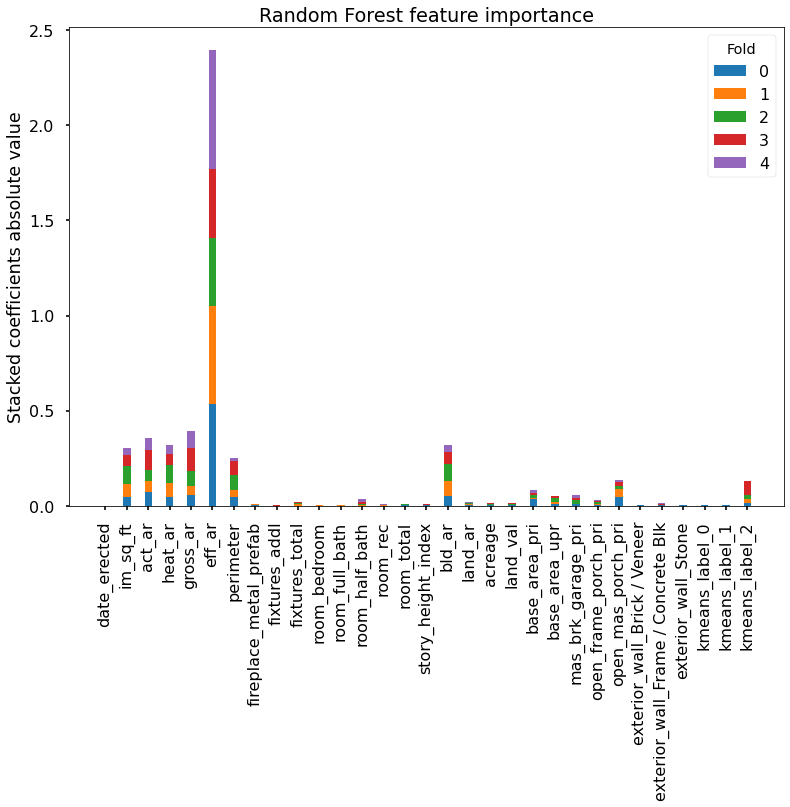

In [46]:
features = X_train.columns
width = 0.35

bottom = np.zeros(len(features))

for fold, values in cv_results.items():
    
    rf_fi = np.abs(values['rf']['features'])
    
    p = plt.bar(features, rf_fi, width, bottom=bottom, label=fold)
    
    bottom += rf_fi
    
_ = plt.xticks(rotation=90)
_ = plt.legend(title='Fold', title_fontsize='x-large')
_ = plt.ylabel('Stacked coefficients absolute value')
_ = plt.title('Random Forest feature importance')

By far, the most significant feature is the effective area (`eff_ar`). The other area related features have a significant contribution each, except for the land area.

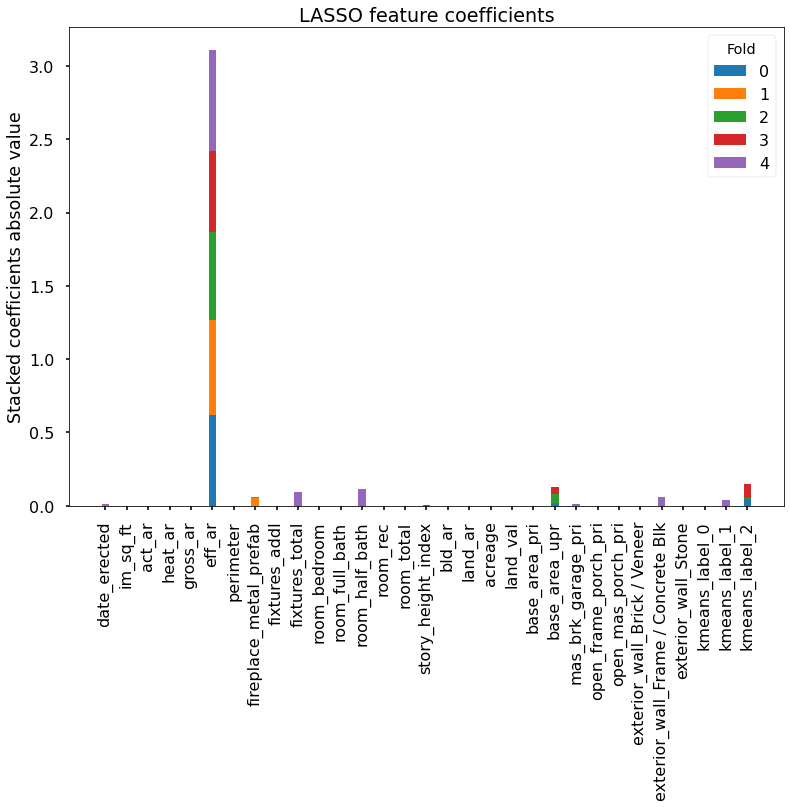

In [47]:
features = X_train.columns
width = 0.35

bottom = np.zeros(len(features))

for fold, values in cv_results.items():
    
    lasso_fi = np.abs(values['lasso']['coeff'])
    
    p = plt.bar(features, lasso_fi, width, bottom=bottom, label=fold)
    
    bottom += lasso_fi
    
_ = plt.xticks(rotation=90)
_ = plt.legend(title='Fold', title_fontsize='x-large')
_ = plt.ylabel('Stacked coefficients absolute value')
_ = plt.title('LASSO feature coefficients')

As in the case with random forest, the effective area is the dominant feature in the LASSO estimator. Nonetheless, the ridge regression estimator after feature elimination is out performed by the ridge regression with all the features, suggesting that even though the contribution from the other variables is small, it helps reduce the test error.

# Fit development ridge regression
We determined that ridge regression was the best estimator, and that the penalty term alpha value of 100 was preferred by 4 out of the 5 folds in cross-validation. Next, let's built a ridge regression estimator using alpha equal to 100 and all the data on the train set, and then score this model with the test set (unseen yet).

In [48]:
from sklearn.linear_model import Ridge

In [49]:
# Standardize variables
sc_x = StandardScaler()
sc_y = StandardScaler()
sc_x.fit(X_train)
sc_y.fit(y_train.to_numpy().reshape(-1, 1))

X_train_std = sc_x.transform(X_train)
X_test_std = sc_x.transform(X_test)

y_train_std = sc_y.transform(y_train.to_numpy().reshape(-1, 1)).ravel()
y_test_std = sc_y.transform(y_test.to_numpy().reshape(-1, 1)).ravel()

In [50]:
# Fit model
rr_dev = Ridge(alpha=100)
rr_dev.fit(X_train_std, y_train_std)

Ridge(alpha=100)

In [51]:
# Calculate train residuals
y_train_pred_std = rr_dev.predict(X_train_std)
y_train_pred = sc_y.inverse_transform(y_train_pred_std)

residuals_train = y_train - y_train_pred

In [52]:
# Calculate test residuals

y_pred_std = rr_dev.predict(X_test_std)
y_pred = sc_y.inverse_transform(y_pred_std)

residuals_test = y_test - y_pred

In [53]:
scores_dev = model_scores(rr_dev, X_train_std, y_train_std, X_test_std, y_test_std, sc_y)

In [54]:
scores_dev

{'train_scores': {'mae': 7395.20417572804,
  'mse': 192568036.8778021,
  'medae': 4218.79337023088},
 'test_scores': {'mae': 6822.834359149198,
  'mse': 69998123.65572518,
  'medae': 5931.989854287036}}

## Save development model

In [55]:
save_fn = ROOT_DIR / 'models/rr_dev.pickle'
save_pickle(rr_dev, save_fn)

save_fn = ROOT_DIR / 'models/scores_dev.pickle'
save_pickle(scores_dev, save_fn)

## Residuals plot

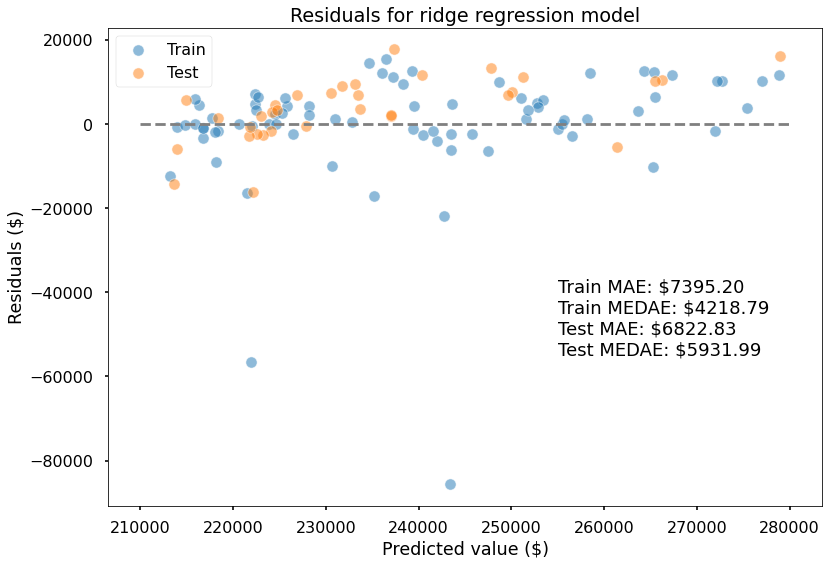

In [56]:
sns.scatterplot(x=y_train_pred, y=residuals_train, alpha=0.5, label='Train')
sns.scatterplot(x=y_pred, y=residuals_test, alpha=0.5, label='Test')
_ = plt.hlines(0, 210_000, 280_000, label='Perfect prediction', color='grey', linestyles='dashed')
_ = plt.ylabel('Residuals ($)')
_ = plt.xlabel('Predicted value ($)')
_ = plt.title('Residuals for ridge regression model')

_ = plt.text(255_000, -40_000, f"Train MAE: ${scores_dev['train_scores']['mae']:.2f}", fontsize=18)
_ = plt.text(255_000, -45_000, f"Train MEDAE: ${scores_dev['train_scores']['medae']:.2f}", fontsize=18)
_ = plt.text(255_000, -50_000, f"Test MAE: ${scores_dev['test_scores']['mae']:.2f}", fontsize=18)
_ = plt.text(255_000, -55_000, f"Test MEDAE: ${scores_dev['test_scores']['medae']:.2f}", fontsize=18)

On the test data, the majority of the residuals are positive, indicating that the model tends to underpredict the property value.

## Prediction error plot

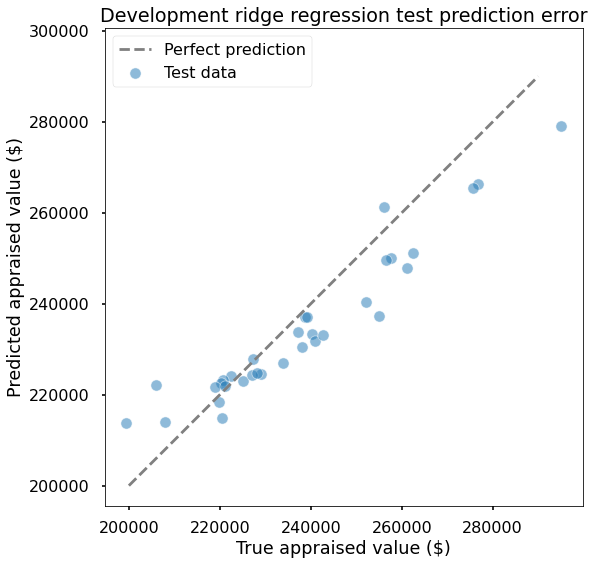

In [57]:
id_x = [200_000, 290_000]
id_y = id_x

ax = sns.scatterplot(x=y_test, y=y_pred, alpha=0.5, label='Test data')
_ = plt.plot(id_x, id_y, label='Perfect prediction', linestyle='--', color='grey')
_ = plt.axis('square')
_ = plt.ylabel('Predicted appraised value ($)')
_ = plt.xlabel('True appraised value ($)')
_ = plt.title('Development ridge regression test prediction error')
_ = plt.legend()

Most of the properties values are underpredicted.

# Fit production ridge regression
Finally, let's use all the data build the model that we will use to predict the target house appraised value.

In [58]:
# Standardize variables
sc_x = StandardScaler()
sc_y = StandardScaler()

sc_x.fit(X)
sc_y.fit(y.to_numpy().reshape(-1, 1))

X_std = sc_x.transform(X)
y_std = sc_y.transform(y.to_numpy().reshape(-1, 1)).ravel()

In [59]:
# Fit model
rr_prod = Ridge(alpha=100)
rr_prod.fit(X_std, y_std)

Ridge(alpha=100)

## Save production model

In [60]:
save_fn = ROOT_DIR / 'models/rr_prod.pickle'
save_pickle(rr_prod, save_fn)

In [61]:
save_fn = ROOT_DIR / 'models/sc_x.pickle'
save_pickle(sc_x, save_fn)

save_fn = ROOT_DIR / 'models/sc_y.pickle'
save_pickle(sc_y, save_fn)

# Predict target house appraised value

In [62]:
target_house_fn = ROOT_DIR / 'data/processed/target_house.pickle'

In [63]:
target_house = pd.read_pickle(target_house_fn)

In [64]:
target_house.drop('tot_appr_val', inplace=True)

In [65]:
target_house.drop(drop, inplace=True)

In [66]:
target_house

date_erected                        2014
im_sq_ft                            2697
act_ar                              3351
heat_ar                             2697
gross_ar                            3351
eff_ar                              2824
perimeter                            430
fireplace_metal_prefab                 1
fixtures_addl                          2
fixtures_total                        15
room_bedroom                           4
room_full_bath                         3
room_half_bath                         1
room_rec                               2
room_total                             9
story_height_index                     2
bld_ar                              2697
land_ar                             6350
acreage                           0.1458
land_val                           36313
base_area_pri                       1590
base_area_upr                       1107
mas_brk_garage_pri                   420
open_frame_porch_pri                 120
open_mas_porch_p

In [67]:
target_house_enc = enc.transform(target_house[cat_cols].to_numpy().reshape(1, -1)).toarray()

In [68]:
target_house_encoded = target_house.drop(cat_cols)

In [69]:
for feature, val in zip(enc.get_feature_names(cat_cols), *target_house_enc):
    target_house_encoded[feature] = val

In [70]:
target_house_encoded

date_erected                            2014
im_sq_ft                                2697
act_ar                                  3351
heat_ar                                 2697
gross_ar                                3351
eff_ar                                  2824
perimeter                                430
fireplace_metal_prefab                     1
fixtures_addl                              2
fixtures_total                            15
room_bedroom                               4
room_full_bath                             3
room_half_bath                             1
room_rec                                   2
room_total                                 9
story_height_index                         2
bld_ar                                  2697
land_ar                                 6350
acreage                               0.1458
land_val                               36313
base_area_pri                           1590
base_area_upr                           1107
mas_brk_ga

In [71]:
target_house_encoded_std = sc_x.transform(target_house_encoded.to_numpy().reshape(1, -1))

In [72]:
y_pred_std = rr_prod.predict(target_house_encoded_std)

In [73]:
y_pred = sc_y.inverse_transform(y_pred_std)[0]

In [74]:
print(f'The predicted appraised value for the target house is: ${y_pred:.2f}')

The predicted appraised value for the target house is: $258695.51
